# Regularization and Evaluation of Neural Networks

In [2]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

In [3]:
# If you don't have scikeras installed, uncomment and run

# pip install scikeras

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [4]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [5]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 792us/step - loss: 0.6788 - accuracy: 0.7307
Epoch 2/50
180/180 [==============================] - 0s 778us/step - loss: 0.4158 - accuracy: 0.8893
Epoch 3/50
180/180 [==============================] - 0s 860us/step - loss: 0.3560 - accuracy: 0.9232
Epoch 4/50
180/180 [==============================] - 0s 793us/step - loss: 0.3089 - accuracy: 0.9438
Epoch 5/50
180/180 [==============================] - 0s 767us/step - loss: 0.2599 - accuracy: 0.9566
Epoch 6/50
180/180 [==============================] - 0s 1ms/step - loss: 0.2065 - accuracy: 0.9627
Epoch 7/50
180/180 [==============================] - 0s 772us/step - loss: 0.1374 - accuracy: 0.9588
Epoch 8/50
180/180 [==============================] - 0s 751us/step - loss: 0.0940 - accuracy: 0.9661
Epoch 9/50
180/180 [==============================] - 0s 757us/step - loss: 0.0752 - accuracy: 0.9733
Epoch 10/50
180/180 [==============================] - 0s 747us/step - loss: 0.0668 

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [7]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [8]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 931us/step - loss: 0.7211 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7154 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7109 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7021 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7004 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [9]:
results.__dict__

{'validation_data': None,
 'model': <keras.src.engine.sequential.Sequential at 0x7fea826f1d30>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7210773825645447,
   0.7154002785682678,
   0.7109240293502808,
   0.7071137428283691,
   0.7043195962905884,
   0.7021074891090393,
   0.7003837823867798,
   0.6989787817001343,
   0.6977455615997314,
   0.6967890858650208],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

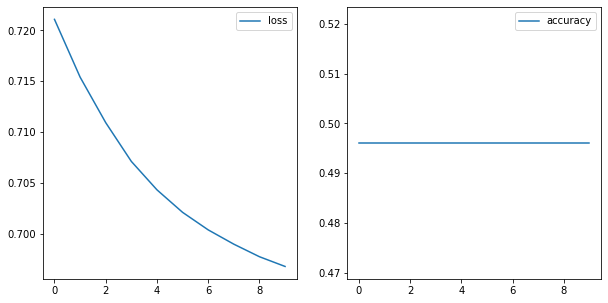

In [10]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [11]:
X_pure_train.shape[0]

1149

In [12]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 874us/step - loss: 0.6890 - accuracy: 0.5466
Epoch 2/100
36/36 [==============================] - 0s 903us/step - loss: 0.6840 - accuracy: 0.6075
Epoch 3/100
36/36 [==============================] - 0s 914us/step - loss: 0.6753 - accuracy: 0.6057
Epoch 4/100
36/36 [==============================] - 0s 936us/step - loss: 0.6661 - accuracy: 0.6057
Epoch 5/100
36/36 [==============================] - 0s 851us/step - loss: 0.6584 - accuracy: 0.5988
Epoch 6/100
36/36 [==============================] - 0s 851us/step - loss: 0.6517 - accuracy: 0.6153
Epoch 7/100
36/36 [==============================] - 0s 857us/step - loss: 0.6449 - accuracy: 0.6319
Epoch 8/100
36/36 [==============================] - 0s 894us/step - loss: 0.6375 - accuracy: 0.6362
Epoch 9/100
36/36 [==============================] - 0s 886us/step - loss: 0.6296 - accuracy: 0.6554
Epoch 10/100
36/36 [==============================] - 0s 940us/step - loss: 0.6210 - accura

36/36 [==============================] - 0s 838us/step - loss: 0.1489 - accuracy: 0.9339
Epoch 82/100
36/36 [==============================] - 0s 889us/step - loss: 0.1471 - accuracy: 0.9339
Epoch 83/100
36/36 [==============================] - 0s 795us/step - loss: 0.1443 - accuracy: 0.9356
Epoch 84/100
36/36 [==============================] - 0s 843us/step - loss: 0.1435 - accuracy: 0.9365
Epoch 85/100
36/36 [==============================] - 0s 808us/step - loss: 0.1424 - accuracy: 0.9382
Epoch 86/100
36/36 [==============================] - 0s 934us/step - loss: 0.1402 - accuracy: 0.9417
Epoch 87/100
36/36 [==============================] - 0s 823us/step - loss: 0.1389 - accuracy: 0.9417
Epoch 88/100
36/36 [==============================] - 0s 952us/step - loss: 0.1375 - accuracy: 0.9399
Epoch 89/100
36/36 [==============================] - 0s 830us/step - loss: 0.1355 - accuracy: 0.9426
Epoch 90/100
36/36 [==============================] - 0s 929us/step - loss: 0.1349 - accuracy: 

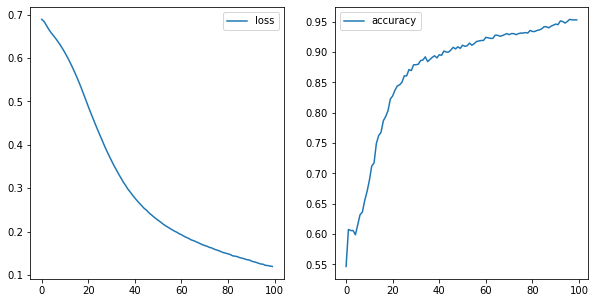

In [13]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 819us/step - loss: 2.7159 - accuracy: 0.4917
Epoch 2/30
115/115 [==============================] - 0s 756us/step - loss: 0.9667 - accuracy: 0.4978
Epoch 3/30
115/115 [==============================] - 0s 907us/step - loss: 1.0972 - accuracy: 0.4691
Epoch 4/30
115/115 [==============================] - 0s 799us/step - loss: 0.9676 - accuracy: 0.4996
Epoch 5/30
115/115 [==============================] - 0s 760us/step - loss: 0.9642 - accuracy: 0.5013
Epoch 6/30
115/115 [==============================] - 0s 745us/step - loss: 0.9526 - accuracy: 0.5152
Epoch 7/30
115/115 [==============================] - 0s 877us/step - loss: 1.0054 - accuracy: 0.5091
Epoch 8/30
115/115 [==============================] - 0s 793us/step - loss: 0.9692 - accuracy: 0.4978
Epoch 9/30
115/115 [==============================] - 0s 813us/step - loss: 1.0257 - accuracy: 0.4970
Epoch 10/30
115/115 [==============================] - 0s 785us/step - loss: 0.966

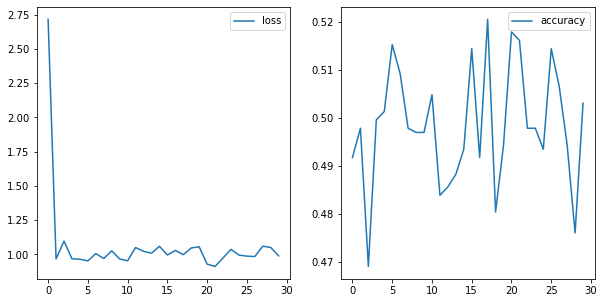

In [14]:
model = Sequential()

sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [15]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

KeyError: 'val_loss'

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [16]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.src.engine.sequential.Sequential object at 0x7fea71fa7d00> does not.

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
keras_model = KerasClassifier(build_model,
                              epochs=50,
                              batch_size=32,
                              verbose=2)

In [19]:
type(keras_model)

scikeras.wrappers.KerasClassifier

In [20]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 1s - loss: 0.6613 - accuracy: 0.6409 - 539ms/epoch - 19ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6119 - accuracy: 0.7356 - 28ms/epoch - 969us/step
Epoch 3/50
29/29 - 0s - loss: 0.5501 - accuracy: 0.7911 - 34ms/epoch - 1ms/step
Epoch 4/50
29/29 - 0s - loss: 0.4788 - accuracy: 0.8313 - 25ms/epoch - 862us/step
Epoch 5/50
29/29 - 0s - loss: 0.4125 - accuracy: 0.8509 - 26ms/epoch - 900us/step
Epoch 6/50
29/29 - 0s - loss: 0.3607 - accuracy: 0.8629 - 23ms/epoch - 788us/step
Epoch 7/50
29/29 - 0s - loss: 0.3115 - accuracy: 0.8749 - 25ms/epoch - 879us/step
Epoch 8/50
29/29 - 0s - loss: 0.2745 - accuracy: 0.8901 - 27ms/epoch - 933us/step
Epoch 9/50
29/29 - 0s - loss: 0.2507 - accuracy: 0.9032 - 26ms/epoch - 894us/step
Epoch 10/50
29/29 - 0s - loss: 0.2315 - accuracy: 0.9097 - 29ms/epoch - 986us/step
Epoch 11/50
29/29 - 0s - loss: 0.2112 - accuracy: 0.9173 - 23ms/epoch - 800us/step
Epoch 12/50
29/29 - 0s - loss: 0.1939 - accuracy: 0.9227 - 28ms/epoch - 964us/step
Epoch 13/50
29/

Epoch 50/50
29/29 - 0s - loss: 0.1426 - accuracy: 0.9891 - 28ms/epoch - 956us/step
8/8 - 0s - 46ms/epoch - 6ms/step
Epoch 1/50
29/29 - 1s - loss: 0.6899 - accuracy: 0.5082 - 536ms/epoch - 18ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6547 - accuracy: 0.5974 - 28ms/epoch - 973us/step
Epoch 3/50
29/29 - 0s - loss: 0.6143 - accuracy: 0.6257 - 29ms/epoch - 984us/step
Epoch 4/50
29/29 - 0s - loss: 0.5636 - accuracy: 0.7345 - 26ms/epoch - 899us/step
Epoch 5/50
29/29 - 0s - loss: 0.5196 - accuracy: 0.8118 - 24ms/epoch - 832us/step
Epoch 6/50
29/29 - 0s - loss: 0.4900 - accuracy: 0.8390 - 27ms/epoch - 924us/step
Epoch 7/50
29/29 - 0s - loss: 0.4694 - accuracy: 0.8629 - 21ms/epoch - 726us/step
Epoch 8/50
29/29 - 0s - loss: 0.4543 - accuracy: 0.8716 - 23ms/epoch - 793us/step
Epoch 9/50
29/29 - 0s - loss: 0.4354 - accuracy: 0.8890 - 23ms/epoch - 803us/step
Epoch 10/50
29/29 - 0s - loss: 0.4201 - accuracy: 0.8934 - 21ms/epoch - 711us/step
Epoch 11/50
29/29 - 0s - loss: 0.4071 - accuracy: 0.9021 - 24ms

Epoch 49/50
29/29 - 0s - loss: 0.1541 - accuracy: 0.9891 - 21ms/epoch - 738us/step
Epoch 50/50
29/29 - 0s - loss: 0.1484 - accuracy: 0.9902 - 21ms/epoch - 733us/step
8/8 - 0s - 41ms/epoch - 5ms/step
Epoch 1/50
29/29 - 1s - loss: 0.6882 - accuracy: 0.5174 - 666ms/epoch - 23ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6627 - accuracy: 0.5663 - 24ms/epoch - 831us/step
Epoch 3/50
29/29 - 0s - loss: 0.6355 - accuracy: 0.6370 - 25ms/epoch - 862us/step
Epoch 4/50
29/29 - 0s - loss: 0.6034 - accuracy: 0.7033 - 25ms/epoch - 853us/step
Epoch 5/50
29/29 - 0s - loss: 0.5659 - accuracy: 0.7815 - 21ms/epoch - 711us/step
Epoch 6/50
29/29 - 0s - loss: 0.5245 - accuracy: 0.8315 - 23ms/epoch - 809us/step
Epoch 7/50
29/29 - 0s - loss: 0.4928 - accuracy: 0.8598 - 23ms/epoch - 785us/step
Epoch 8/50
29/29 - 0s - loss: 0.4664 - accuracy: 0.8750 - 22ms/epoch - 760us/step
Epoch 9/50
29/29 - 0s - loss: 0.4455 - accuracy: 0.8870 - 25ms/epoch - 848us/step
Epoch 10/50
29/29 - 0s - loss: 0.4300 - accuracy: 0.8891 - 22ms

array([0.95652174, 0.95652174, 0.93913043, 0.93913043, 0.89082969])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

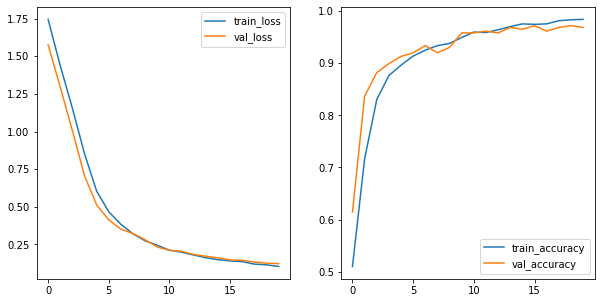

In [21]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

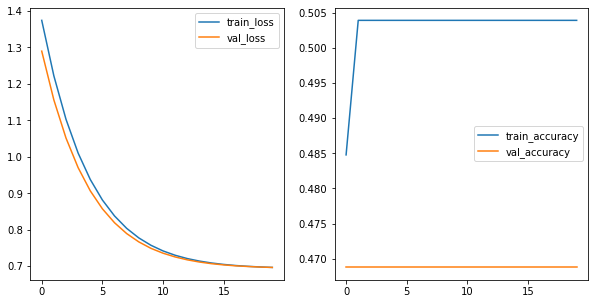

In [22]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](/images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

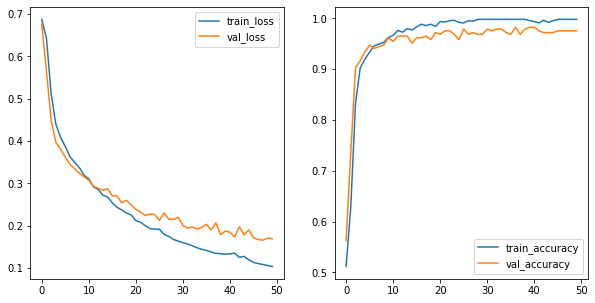

In [23]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [24]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 15: early stopping


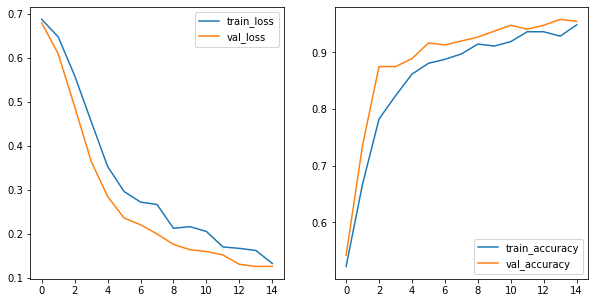

In [25]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 31: early stopping


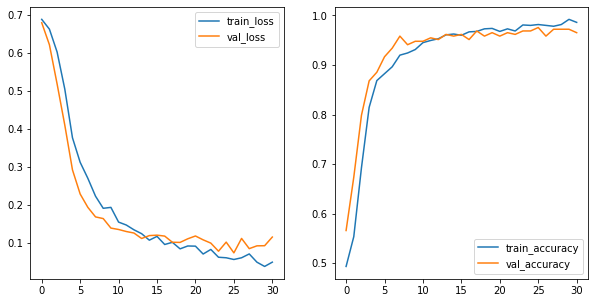

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [28]:
results.history['val_accuracy'][-1]

0.9652777910232544

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [29]:
digits = load_digits()
X = digits.data
y = digits.target

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [31]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/Users/charlesrice/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 2ms/step - loss: 2.2019 - accuracy: 0.2045 - val_loss: 2.1103 - val_accuracy: 0.2708
Epoch 2/50
115/115 [==============================] - 0s 1ms/step - loss: 1.9112 - accuracy: 0.3812 - val_loss: 1.7703 - val_accuracy: 0.4688
Epoch 3/50
115/115 [==============================] - 0s 1ms/step - loss: 1.4800 - accuracy: 0.5918 - val_loss: 1.3175 - val_accuracy: 0.6354
Epoch 4/50
115/115 [==============================] - 0s 1ms/step - loss: 1.0838 - accuracy: 0.6971 - val_loss: 1.0064 - val_accuracy: 0.7639
Epoch 5/50
115/115 [==============================] - 0s 1ms/step - loss: 0.8423 - accuracy: 0.7763 - val_loss: 0.8286 - val_accuracy: 0.7708
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.8059 - val_loss: 0.7144 - val_accuracy: 0.7812
Epoch 7/50
115/115 [==============================] - 0s 1ms/step - loss: 0.5962 - accuracy: 0.8285 - val_loss: 0.6453 - val_accuracy: 0.7951
Epoch 

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [34]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

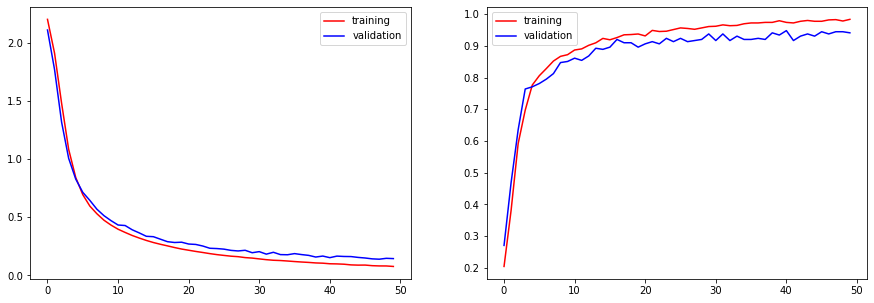

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [36]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 623us/step


In [37]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 29,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 33,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 27,  1],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0, 38]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
